In [1]:
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz


In [2]:
def f(x):
    return torch.sin(20 * x) + 2 * torch.cos(14 * x) - 2 * torch.sin(6 * x)

In [3]:
X = torch.tensor([-1, -1/2, 0, 1/2, 1])
y = f(X)
y

tensor([-1.1983,  2.3341,  2.0000,  0.6815,  1.7453])

In [4]:
kernel = gp.kernels.RBF(input_dim=1)
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10**(-4)))

In [5]:
def f_model(x):
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
    loc, var = gpr(x, noiseless = False, full_cov = False)
    pyro.sample("loc", dist.Delta(loc))
    pyro.sample("var", dist.Delta(var))
    pyro.sample("f", dist.Normal(loc, var))

In [6]:
C = 4
W = 100

In [7]:
nuts_kernel=pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc=pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=C, warmup_steps=W)
mcmc.run()

Warmup [1]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/600 [00:00, ?it/s]

c:\Users\Jacki\anaconda3\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
c:\Users\Jacki\anaconda3\lib\site-packages\torch\autograd\__init__.py:300: UserWarning: operator () profile_node %1383 : int[] = prim::profile_ivalue(%1381)
 does not have profile information (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\codegen\cuda\graph_fuser.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


c:\Users\Jacki\anaconda3\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


                     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.238  0.156     0.003      0.516      0.008    0.005   
kernel.variance     2.248  1.237     0.808      4.933      0.070    0.049   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     363.0     562.0   1.00  
kernel.variance        439.0     276.0   1.01  


array([<AxesSubplot:title={'center':'kernel.lengthscale'}>,
       <AxesSubplot:title={'center':'kernel.variance'}>], dtype=object)

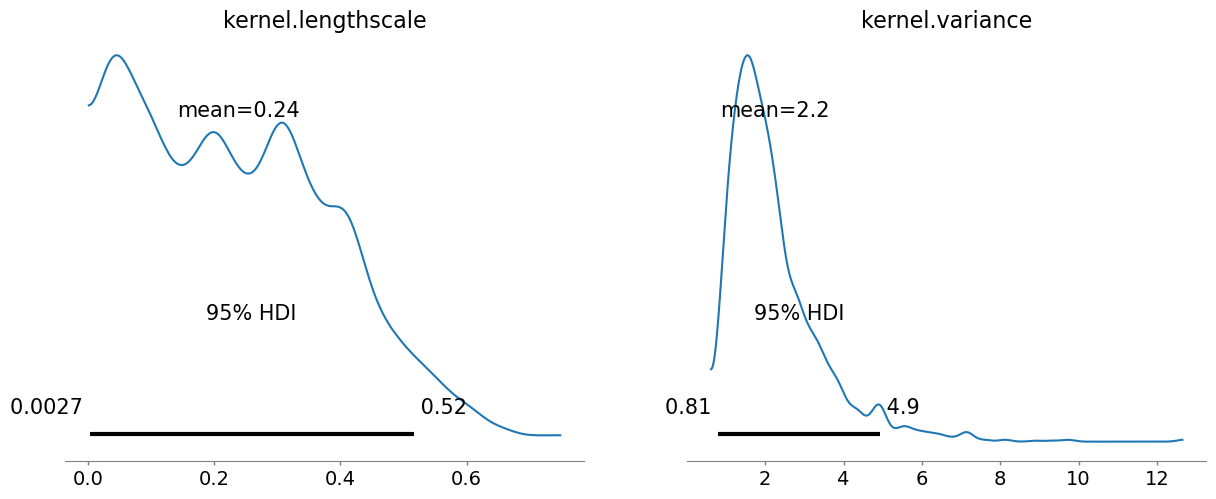

In [8]:
data = arviz.from_pyro(mcmc)
# Specify we want 95% credible interval (hdi=high density interval)
summary = arviz.summary(data, hdi_prob=0.95)
print(summary)
arviz.plot_posterior(data, hdi_prob=0.95)

In [9]:
posterior_samples=mcmc.get_samples()

In [10]:
x = torch.tensor([-1/4])

In [11]:
posterior_predictive = pyro.infer.Predictive(f_model, posterior_samples = posterior_samples)(x)


In [17]:
posterior_predictive['loc']

tensor([[2.7162],
        [1.4577],
        [2.0374],
        ...,
        [2.8032],
        [2.8026],
        [2.8026]])

In [13]:
def algo1(X, y, XNew, T, C = 4, W = 100):
    kernel = gp.kernels.RBF(input_dim=1)
    kernel.variance = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
    kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
    X_k, y_k = X, y
    #gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10**(-4)))
    #nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
    #mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1,
    #                    num_chains=C, warmup_steps=W)
    #mcmc.run()
    fs_list = []
    mean_list = []
    var_list = []
    min_list = []
    for k in range(T):
        gpr = gp.models.GPRegression(
            X_k, y_k, kernel, noise=torch.tensor(10**(-4)))
        nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
        mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1,
                        num_chains=C, warmup_steps=W)
        mcmc.run()
        posterior_samples=mcmc.get_samples()
        posterior_predictive = pyro.infer.Predictive(
            f_model, posterior_samples=posterior_samples)(XNew)
        fs = posterior_predictive['f'].mean(dim = 0)
        fs_list.append(fs)
        mean_list.append(posterior_predictive['loc'].mean(dim = 0))
        var_list.append(posterior_predictive['var'].mean(dim = 0))
        idx = torch.argmin(fs)
        X_min = XNew[idx]
        y_min = f(X_min)
        min_list.append([X_min, y_min])
        X_k = torch.concat((X_k, X_min.reshape(1)))
        y_k = torch.concat((y_k, y_min.reshape(1)))
        pyro.clear_param_store()
        #gpr.X = torch.concat((gpr.X, XNew[idx]))
        #gpr.y = torch.concat((gpr.y, torch.tensor([min])))
    return fs_list, mean_list, var_list, min_list

In [14]:
XNew = torch.linspace(-1, 1, steps = 200)
T = 10

In [16]:
fs_list, mean_list, var_list, min_list = algo1(X, y, XNew, T)


Warmup [1]:   0%|          | 0/101 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/101 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/101 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/101 [00:00, ?it/s]

c:\Users\Jacki\anaconda3\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


TypeError: 'dict' object is not callable